In [36]:
import scanpy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import muon
import mofax
import torch
import random

In [2]:
device = torch.device('cpu')


In [5]:
# pbmc = scanpy.read_10x_h5('5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5', gex_only=False)
pbmc_source = scanpy.read('data.h5ad', gex_only=False)
pbmc_source.var_names_make_unique()
# pbmc.layers['counts'] = pbmc.X.copy()
# scanpy.pp.filter_genes(pbmc, min_counts=1)


/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [22]:
cell_type_labels = list(set(pbmc_source.obs['cell_type']))
pbmc_source.obs['cell_type_id'] = np.array([cell_type_labels.index(label) for label in pbmc_source.obs['cell_type']])


In [71]:
indices = list[int]()

for cell_type_id in pbmc_source.obs['cell_type_id'].value_counts().index[:12]:
  indices += random.sample(list(np.nonzero(pbmc_source.obs['cell_type_id'] == cell_type_id)[0]), 500)

pbmc = pbmc_source[indices, :]

print(pbmc.obs['cell_type'].value_counts())

cell_type
CD4+ T activated       500
CD4+ T naive           500
CD8+ T naive           500
CD14+ Mono             500
CD16+ Mono             500
Erythroblast           500
G/M prog               500
NK                     500
NK CD158e1+            500
Naive CD20+ B IGKC+    500
Naive CD20+ B IGKC-    500
Reticulocyte           500
Name: count, dtype: int64


In [72]:
# pbmc = pbmc_source[pbmc_source.obs['cell_type_id'] < 6, :]
# pbmc = pbmc[np.random.permutation(pbmc.shape[0])[:2000], :]
# pbmc


In [73]:
data_gene = pbmc[:, pbmc.var['feature_types'] == 'GEX']
data_prot = pbmc[:, pbmc.var['feature_types'] == 'ADT']


## MOFA

In [24]:
mdata = muon.MuData(dict(
  gene_expr=data_gene,
  prot_expr=data_prot
))

mdata


MuData object with n_obs × n_vars = 9000 × 14087
  var:	'feature_types', 'gene_id'
  2 modalities
    gene_expr:	9000 x 13953
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'cell_type_id'
      var:	'feature_types', 'gene_id'
      uns:	'dataset_id', 'genome', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'
    prot_expr:	9000 x 134
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'cell_type_id'
      var:	'feature_types', 'gene_id'
      uns:	'dataset_id', 'genome', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'

In [25]:
muon.tl.mofa(mdata, outfile='result.hdf5', save_data=False, save_metadata=False)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='gene_expr' group='group1' with N=9000 samples and D=13953 features...
Loaded view='prot_expr' group='group1' with N=9000 samples and D=134 features...



Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on th

In [ ]:
model = mofax.mofa_model('result.hdf5')


In [ ]:
mofax.plot_r2(model, x='View')


In [ ]:
mofax.plot_factors(model, x = "Factor1", y="Factor2",  size=20)


## Pyro

In [42]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import pyro.distributions
import torch
# from torch.nn.functional import softplus
# from sklearn.metrics import mean_squared_error
from anndata import AnnData
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import scale


In [43]:

class FA(PyroModule):
  def __init__(self, datas, latent_count: int):
    super().__init__()
    pyro.clear_param_store()

    # self.datas = [torch.as_tensor(data) for data in datas] # samples x variables
    self.datas = datas
    self.latent_count = latent_count
    # self.modality_count = len(self.datas)

    self.sample_count = self.datas[0].shape[0]
    # self.feature_count = self.datas[0].shape[1]

    # self.modality_plate = pyro.plate('modality', self.modality_count)
    self.sample_plate = pyro.plate('sample', self.sample_count, dim=-2)
    # self.feature_plate = pyro.plate('feature', self.feature_count, dim=-2)
    self.latent_factor_plate = pyro.plate('latent factors', self.latent_count, dim=-1)

  def model(self):
    # epss = []

    # for modality_index, modality_size in enumerate(data.shape[1] for data in self.datas):
    #   with pyro.plate(f'feature_{modality_index}p', modality_size):
    #     tau = pyro.sample(f'tau_{modality_index}', pyro.distributions.Gamma(1e-14, 1e-14)).to(device)
    #     eps = pyro.sample(f'eps_{modality_index}', pyro.distributions.Normal(0, 1 / (1e-10 + tau))).to(device)
    #     epss.append(eps)

    with self.latent_factor_plate:
      with self.sample_plate:
        Z = pyro.sample('Z', pyro.distributions.Normal(0, 1)).to(device)

    with self.latent_factor_plate:
      WS = []

      for modality_index, modality_size in enumerate(data.shape[1] for data in self.datas):
        with pyro.plate(f'feature_{modality_index}', modality_size):
          WS.append(pyro.sample(f'W{modality_index}', pyro.distributions.Normal(0, 1)).to(device))

    # Y_hat = [torch.matmul(Z, W.t()) + epss[modality_index] for modality_index, W in enumerate(WS)]
    Y_hat = [torch.matmul(Z, W.t()) for modality_index, W in enumerate(WS)]

    for modality_index, data in enumerate(self.datas):
      with pyro.plate(f'feature_{modality_index}_', data.shape[1]), pyro.plate(f'sample_{modality_index}', self.sample_count):
        scale = pyro.sample(f'scale_{modality_index}', pyro.distributions.LogNormal(0, 1)).to(device)
        pyro.sample(f'obs_{modality_index}', pyro.distributions.Normal(Y_hat[modality_index], scale), obs=data).to(device)


def train(fa: FA, *, epoch_count: int):
  optimizer = pyro.optim.Adam(dict(lr=0.02))
  elbo = Trace_ELBO()
  guide = autoguide.AutoDelta(fa.model)

  svi = SVI(
    model=fa.model,
    guide=guide,
    optim=optimizer,
    loss=elbo
  )

  train_losses = np.empty(epoch_count)

  for epoch_index in tqdm(list(range(epoch_count))):
    loss = svi.step()
    train_losses[epoch_index] = loss / fa.sample_count

  # map_estimates = guide(fa.datas[0])
  return train_losses, guide


In [74]:
# fa_gene = FA(data_gene.X.toarray(), latent_count=10)
fa = FA([
  torch.as_tensor(data_prot.X.toarray()).to(device),
  torch.as_tensor(data_gene.X.toarray()).to(device)
], latent_count=10)

fa = fa.to(device)

losses, guide = train(fa, epoch_count=200)


  0%|          | 0/200 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'latent factors', 'sample'}
  warnings.warn(
100%|██████████| 200/200 [10:39<00:00,  3.20s/it]


In [76]:
result = guide()


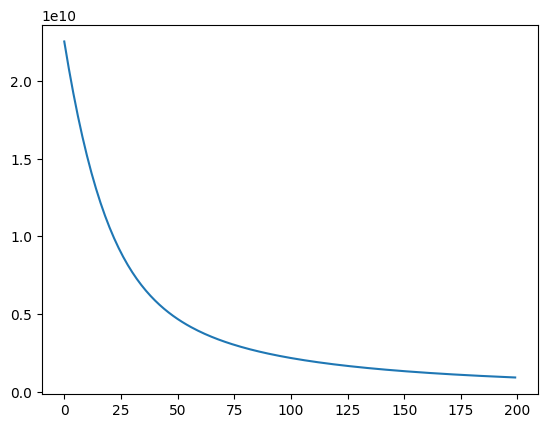

In [77]:
fig, ax = plt.subplots()

ax.plot(losses);


In [78]:
pbmc.obs['cell_type'].value_counts()


cell_type
CD4+ T activated       500
CD4+ T naive           500
CD8+ T naive           500
CD14+ Mono             500
CD16+ Mono             500
Erythroblast           500
G/M prog               500
NK                     500
NK CD158e1+            500
Naive CD20+ B IGKC+    500
Naive CD20+ B IGKC-    500
Reticulocyte           500
Name: count, dtype: int64

In [79]:
import umap

latent = result['Z'].detach()
print(latent.size())

reducer = umap.UMAP()
embedding = reducer.fit_transform(scale(latent))


torch.Size([6000, 10])


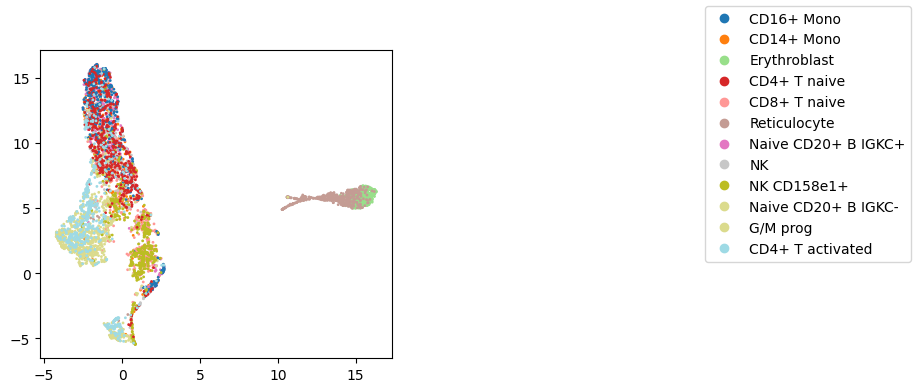

In [84]:
# fig, (ax, _) = plt.subplots(ncols=2, figsize=(10, 4))
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)

cell_type_ids = list(np.unique(pbmc.obs['cell_type_id']))
cell_type_labels = list(set(pbmc.obs['cell_type']))
cell_types = [cell_type_labels.index(label) for label in pbmc.obs['cell_type']]

scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=pbmc.obs['cell_type_id'], cmap='tab20', s=1);

fig.legend(
  *scatter.legend_elements(num=cell_type_ids, fmt=FuncFormatter(lambda x, y: cell_type_labels[cell_type_ids.index(x)])),
  ncol=1
);


In [75]:
with open('output3.png', 'wb') as file:
  fig.savefig(file, dpi=288)

/opt/homebrew/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


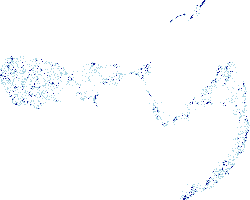

In [23]:
import datashader
from datashader.mpl_ext import dsshow, alpha_colormap
# import pa

df = pd.DataFrame(dict(
  x=embedding[:, 0],
  y=embedding[:, 1],
  cell_type=pd.Categorical(pbmc.obs['cell_type'])
))

cvs = datashader.Canvas(plot_width=250, plot_height=200)
agg = cvs.points(df, 'x', 'y')
img = datashader.tf.shade(agg)

# fig, ax = plt.subplots()
# artist = dsshow(df, datashader.Point('x', 'y'), datashader.count_cat('cell_type'), ax=ax)

# fig.legend(
#   # *scatter.legend_elements(num=range(len(np.unique(pbmc.obs['cell_type_id']))), fmt=FuncFormatter(lambda x, y: cell_type_labels[x])),
#   handles=artist.get_legend_elements(),
# )

datashader.utils.export_image(img, filename='output')
